## Purpose
Since a lot of people ask me about the ROC curve when I show the precision-recall curve, I will show both.

In [4]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

rf_best_params = {'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_samples': None,
 'max_leaf_nodes': 50,
 'max_features': 0.5,
 'max_depth': 10,
 'criterion': 'gini',
 'ccp_alpha': 0,
 'bootstrap': True}

rf = RandomForestClassifier(random_state=2020, class_weight = 'balanced_subsample')
rf.set_params(**rf_best_params)
xgbrf = pickle.load(open('../models/xgbrf.pkl', 'rb'))


In [2]:
fold1 = pd.read_csv('../data/final/fold1.csv')
fold2 = pd.read_csv('../data/final/fold2.csv')
fold3 = pd.read_csv('../data/final/fold3.csv')
fold4 = pd.read_csv('../data/final/fold4.csv')

fold1.set_index('Unnamed: 0', inplace=True)
fold2.set_index('Unnamed: 0', inplace=True)
fold3.set_index('Unnamed: 0', inplace=True)
fold4.set_index('Unnamed: 0', inplace=True)
columns = ['BUN', 'bicarbonate', 'calcium', 'chloride',
           'creatinine', 'glucose', 'potassium', 'sodium',
           'BUN_min', 'BUN_mean', 'BUN_max', 'BUN_var', 'bicarbonate_min',
           'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_var', 'calcium_min',
           'calcium_mean', 'calcium_max', 'calcium_var', 'chloride_min',
           'chloride_mean', 'chloride_max', 'chloride_var', 'creatinine_min',
           'creatinine_mean', 'creatinine_max', 'creatinine_var', 'glucose_min',
           'glucose_mean', 'glucose_max', 'glucose_var', 'potassium_min',
           'potassium_mean', 'potassium_max', 'potassium_var', 'sodium_min',
           'sodium_mean', 'sodium_max', 'sodium_var'
          ]

def relabel_data(df):
    df['time_to_detect'] = pd.to_timedelta(df['time_to_detect'])
    df.loc[df['time_to_detect']<=pd.Timedelta('36h'), 'positive_window'] = 1
    return df
fold1 = relabel_data(fold1)
fold2 = relabel_data(fold2)
fold3 = relabel_data(fold3)
fold4 = relabel_data(fold4)

X_train = pd.concat([fold1[columns], fold2[columns], fold3[columns]], axis=0)
print(X_train.shape)
y_train = pd.concat([fold1['positive_window'], fold2['positive_window'], fold3['positive_window']], axis=0)
print(y_train.shape)
X_test = fold4[columns]
print(X_test.shape)
y_test = fold4['positive_window']
print(y_test.shape)
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

/Users/zhannahakhverdyan/anaconda3/envs/predict_dialisys_need/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(132164, 40)
(132164,)
(43720, 40)
(43720,)
0.12974032262946036
0.1334858188472095


In [3]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features=0.5, max_leaf_nodes=50,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=2020, verbose=0, warm_start=False)

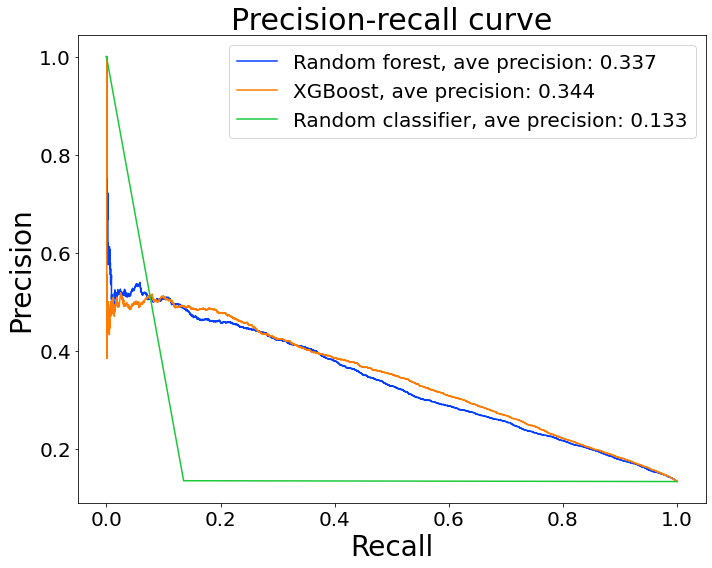

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
sns.set_palette("bright")

# create a random classifier for comparison
y_rand = np.zeros(43720)
y_rand[:5836] = 1
np.random.shuffle(y_rand)
precision_r, recall_r, pr_th_r = precision_recall_curve(y_test, y_rand)

y_pred_rf = rf.predict_proba(X_test)[:,1]
precision_rf, recall_rf, pr_th_rf = precision_recall_curve(y_test, y_pred_rf)

y_pred_xgb = xgbrf.predict_proba(X_test)[:,1]
precision_xgb, recall_xgb, pr_th_xgb = precision_recall_curve(y_test, y_pred_xgb)


plt.figure(figsize=(10,8))
plt.plot(recall_rf, precision_rf, label='Random forest, ave precision: 0.337')
plt.plot(recall_xgb, precision_xgb, label='XGBoost, ave precision: 0.344')
plt.plot(recall_r, precision_r, label='Random classifier, ave precision: 0.133')
plt.xlabel('Recall', fontsize=28)
plt.ylabel('Precision', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title('Precision-recall curve', fontsize=30)
plt.tight_layout()
plt.savefig('../images/pr_curve.png')
plt.show()

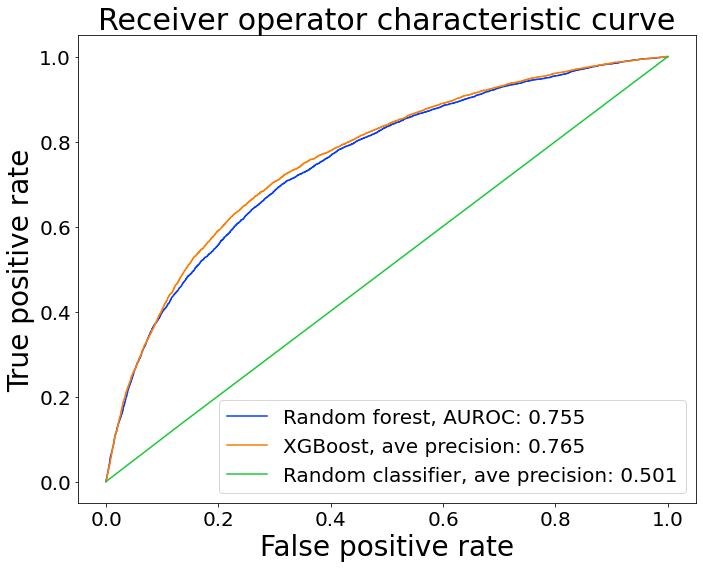

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr_r, tpr_r, thr_r_rand = roc_curve(y_test, y_rand)
fpr_rf, tpr_rf, thr_roc_rf = roc_curve(y_test, y_pred_rf)
fpr_xgb, tpr_xgb, thr_roc_xgb = roc_curve(y_test, y_pred_xgb)

aurock_r = round(roc_auc_score(y_test, y_rand),3)
aurock_rf = round(roc_auc_score(y_test, y_pred_rf),3)
aurock_xgb = round(roc_auc_score(y_test, y_pred_xgb),3)

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label='Random forest, AUROC: {}'.format(aurock_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost, ave precision: {}'.format(aurock_xgb))
plt.plot(fpr_r, tpr_r, label='Random classifier, ave precision: {}'.format(aurock_r))
plt.xlabel('False positive rate', fontsize=28)
plt.ylabel('True positive rate', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title('Receiver operator characteristic curve', fontsize=30)
plt.tight_layout()
plt.savefig('../images/roc_curve.png')
plt.show()

In [12]:
threshold = 0.5190987
np.where(thr_roc_xgb>= 0.5190987)

(array([   0,    1,    2, ..., 4080, 4081, 4082]),)

In [ ]:
fpr_xgb[4082]
tpr_xgb